In [2]:
import inscopix_cnmfe
import isx
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

Pipeline for Using CellReg:  
For each session:
1) Need to convert motion_corrected.isxd to .tif
2) Run cnmfe
3) Isolate accepted footprints from rejected
   1) How to know which footprints align to which cells we have already have documented as accepted?
4) Only use accepted cell as input to matlab

In [10]:
src = '/media/rory/Padlock_DT/BLA_Analysis/PTP_Inscopix_#1/BLA-Insc-1/Pre-RDT RM/motion_corrected.isxd'
dst = '/media/rory/Padlock_DT/BLA_Analysis/PTP_Inscopix_#1/BLA-Insc-1/Pre-RDT RM/motion_corrected.tif'
isx.export_movie_to_tiff(src, dst)

In [11]:
footprints, traces = inscopix_cnmfe.run_cnmfe(
    input_movie_path=dst, 
    output_dir_path='output', 
    output_filetype=0,
    average_cell_diameter=7,
    min_pixel_correlation=0.8,
    min_peak_to_noise_ratio=10.0,
    gaussian_kernel_size=0,
    closing_kernel_size=0,
    background_downsampling_factor=2,
    ring_size_factor=1.4,
    merge_threshold=0.7,
    num_threads=4,
    processing_mode=2,
    patch_size=80,
    patch_overlap=20,
    output_units=1,
    deconvolve=0,
    verbose=1
)

In [12]:
from PIL import Image
root = "/media/rory/Padlock_DT/BLA_Analysis/LongReg/CellReg"
print(len(footprints))

for footprint_idx in range(0,len(footprints)):
    img = Image.fromarray(footprints[footprint_idx])
    img.save(f"{root}/cell_{footprint_idx}.tif")

40


<class 'numpy.ndarray'>
(195, 314)


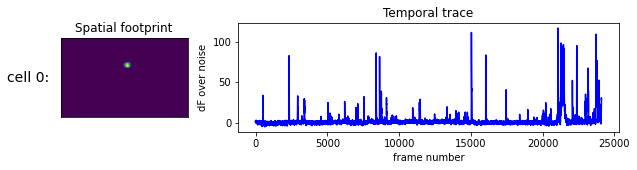

<class 'numpy.ndarray'>
(195, 314)


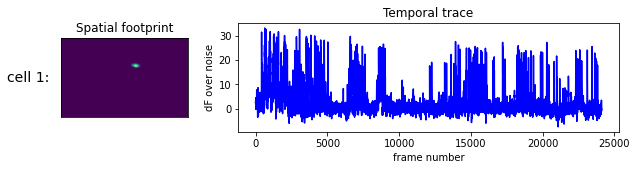

<class 'numpy.ndarray'>
(195, 314)


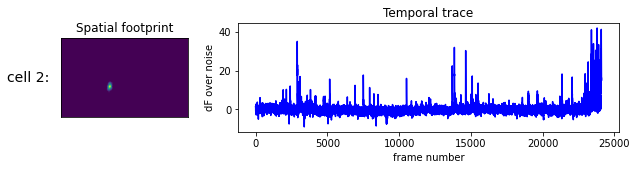

In [7]:
# number of neurons we wish to visualize
num_neurons = 3

for neuron_index in range(num_neurons):
    # instantiate figure
    fig, axes = plt.subplots(1, 2, figsize=(10, 2), gridspec_kw={'width_ratios': [1, 3]})

    # spatial footprint
    axes[0].imshow(footprints[neuron_index])
    axes[0].set_title("Spatial footprint")
    axes[0].grid(False)
    axes[0].set_xticks([])
    axes[0].set_yticks([])

    # temporal dynamics
    axes[1].set_title("Temporal trace")
    axes[1].plot(traces[neuron_index], label='neuron {0}'.format(neuron_index), color='blue')
    axes[1].set_ylabel("dF over noise")
    axes[1].set_xlabel("frame number")
    
    plt.suptitle(
        'cell {0}:'.format(neuron_index), 
        x=0.08,
        y=0.55,
        fontsize=14
    )
    print(type(footprints[neuron_index]))
    print(footprints[neuron_index].shape)
    plt.show()

In [8]:
def plot_footprints_on_grid(footprints, n_cols = 10):
    '''
    Plots all footprints on a grid of axes.
    User specifies number of desired columns
    
    Args:
        footprints (array):
            n_cells x rows x columns array of footprints
        n_cols (int, optional):
            number of columns in plot grid (defaults to 10).
    Returns:
        tuple of fig, ax
            fig = matplotlib figure handle
            ax = array of matplotlib axes handles
    '''

    n_rows = int(np.ceil(np.shape(footprints)[0]/n_cols))
    
    fig, ax = plt.subplots(
        n_rows, 
        n_cols, 
        figsize=(12,1.6*n_rows), 
        sharex=True, 
        sharey=True
    )
    axes = ax.ravel()
    
    for i in range(len(ax.flatten())):
        try:
            axes[i].imshow(footprints[i], cmap='gray')
            axes[i].set_title("cell {}".format(str(i).zfill(2)))
            axes[i].grid(False)
            axes[i].set_xticks([])
            axes[i].set_yticks([])
        except IndexError:
            # turn off axes for where cell doesn't exist
            axes[i].axis('off')
            
    fig.tight_layout()
    fig.subplots_adjust(wspace=0.025, hspace=0.2, top=0.93)
    fig.patch.set_facecolor('white')
    fig.suptitle('all spatial footprints', fontweight='bold');

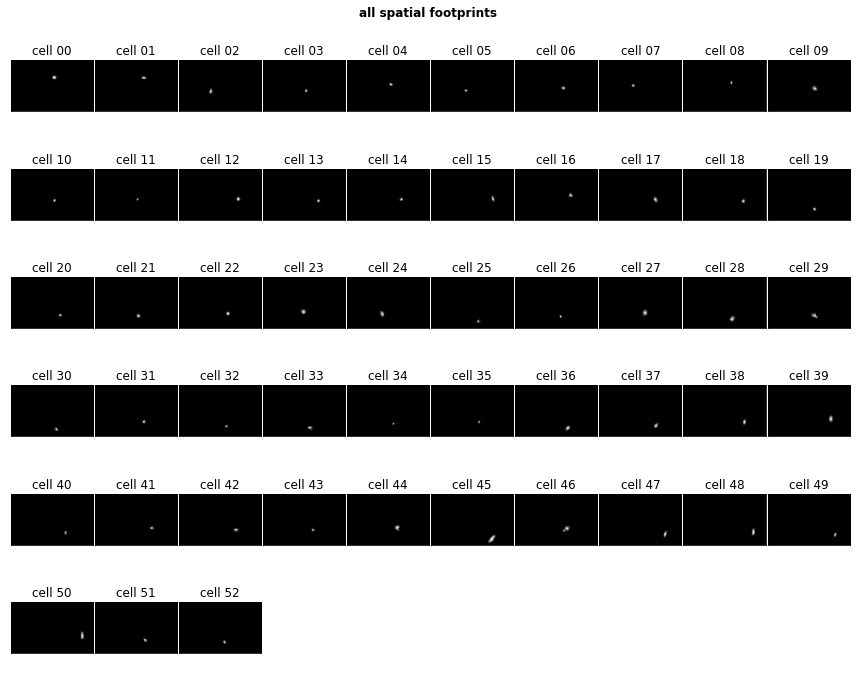

In [9]:
plot_footprints_on_grid(footprints)

In [10]:
def plot_composite_fov(footprints, colormap='gist_rainbow'):
    '''
    Plots all footprints on a single composite field of view.
    
    Args:
        footprints (array):
            n_cells x rows x columns array of footprints
        colormap (str, optional)
            Colormap to use. Each cell will be assigned a random color from this map (defaults to 'gist_rainbow').
    Returns:
        tuple of fig, ax
            fig = matplotlib figure handle
            ax = matplotlib axis handle
    '''
    
    fig, ax = plt.subplots(figsize=(15,15))
    
    # start with an array of zeros
    composite_fov = np.zeros((footprints.shape[1], footprints.shape[2], 3))
    cmap_vals = cm.get_cmap(colormap)
    
    np.random.seed(0)
    for cell_id in range(footprints.shape[0]):
        # select a random color for this cell
        color = cmap_vals(np.random.rand())

        # assign the color to each of the three channels, normalized by the footprint peak
        for color_channel in range(3):
            composite_fov[:,:,color_channel] += color[color_channel]*footprints[cell_id]/np.max(footprints[cell_id])

    # set all values > 1 (where cells overlap) to 1:
    composite_fov[np.where(composite_fov > 1)] = 1

    # show the image
    ax.imshow(composite_fov)

    # annotate each cell with a label centered at its peak
    for cell_id in range(footprints.shape[0]):
        peak_loc = np.where(footprints[cell_id]==np.max(footprints[cell_id]))
        ax.text(
            peak_loc[1][0], 
            peak_loc[0][0], 
            'cell {}'.format(str(cell_id).zfill(2)), 
            color='white', 
            ha='center', 
            va='center',
            fontweight='bold',
        )
        
    fig.tight_layout()
    fig.subplots_adjust(top=0.95)
    fig.patch.set_facecolor('white')
    fig.suptitle('composite field of view', fontweight='bold');
    
    return fig, ax

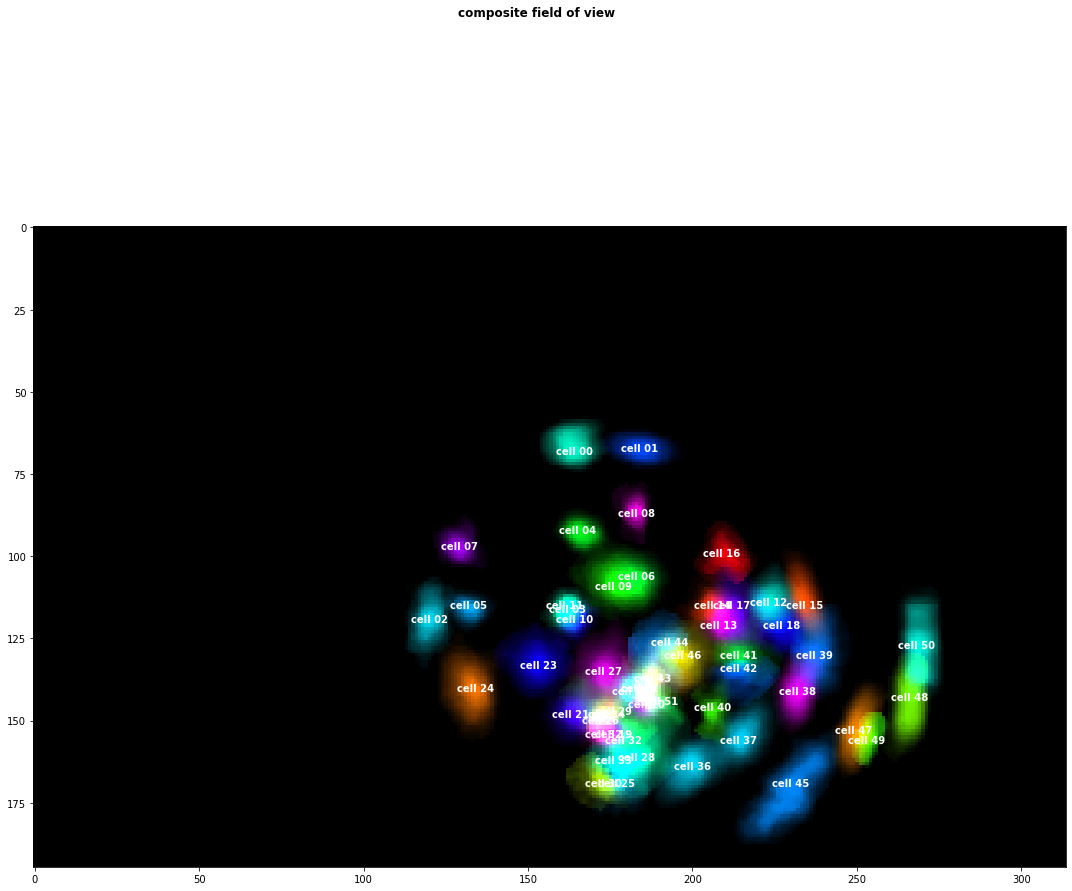

In [11]:
plot_composite_fov(footprints, colormap='gist_rainbow');